## Vehicle Detection and Tracking
- The car images and non-car images are collected to be trained by the classifier.
- 8792 images are present for car images and 8968 images as non car images.
- Data Exploration is done to show the resolution of images and examples of both car and non-car images.

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle


%matplotlib inline


In [11]:
car_images = glob.glob('/home/harshith/Downloads/vehicles/vehicles/**/*.png')
noncar_images = glob.glob('/home/harshith/Downloads/non-vehicles/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: <class 'numpy.uint8'>


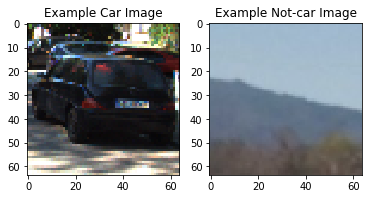

In [12]:
non_vehicles_gti = glob.glob('/home/harshith/Downloads/non-vehicles/non-vehicles/GTI/*.png')
non_vehicles_extras = glob.glob("/home/harshith/Downloads/non-vehicles/non-vehicles/Extras/*.png")

vehicles_gti_far = glob.glob("/home/harshith/Downloads/vehicles/vehicles/GTI_Far/*.png")
vehicles_gti_left = glob.glob("/home/harshith/Downloads/vehicles/vehicles/GTI_Left/*.png")
vehicles_gti_right = glob.glob("/home/harshith/Downloads/vehicles/vehicles/GTI_Right/*.png")
vehicles_gti_middle = glob.glob("/home/harshith/Downloads/vehicles/vehicles/GTI_MiddleClose/*.png")
vehicles_kitti = glob.glob("/home/harshith/Downloads/vehicles/vehicles/KITTI_extracted/*.png")

notcars = np.concatenate((non_vehicles_gti, non_vehicles_extras))
cars = np.concatenate((vehicles_gti_far, vehicles_gti_left, vehicles_gti_right, vehicles_gti_middle, vehicles_kitti))


def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    test_image = cv2.imread(car_list[0])
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = type(test_image[0][0][0])
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig('output_images/car_no_car', bbox_inches='tight')
plt.show()

 


## Histograms of Color
- I have tried different color spaces of histogram and "YCrCb" seems to provide the distinctiveness in car and non car images.
- Different histogram color spaces have been plotted below.
- I tried applying different color spaces as features and YCrCb appears to perform better than HSV and HLS.

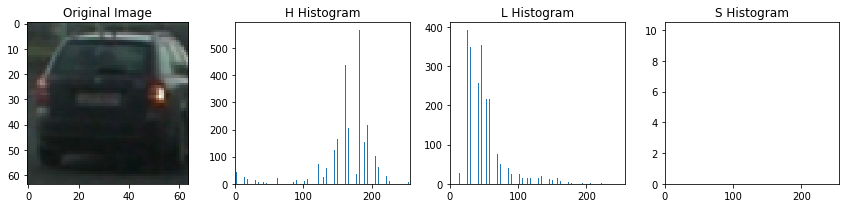

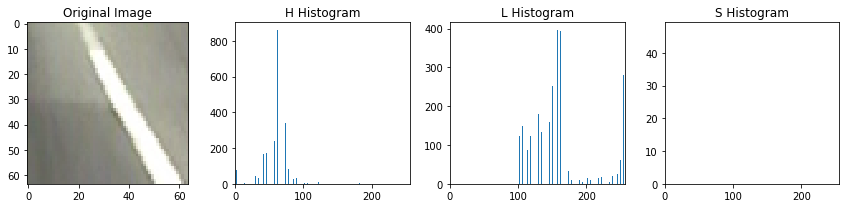

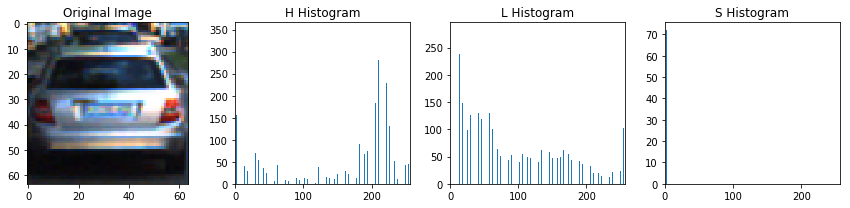

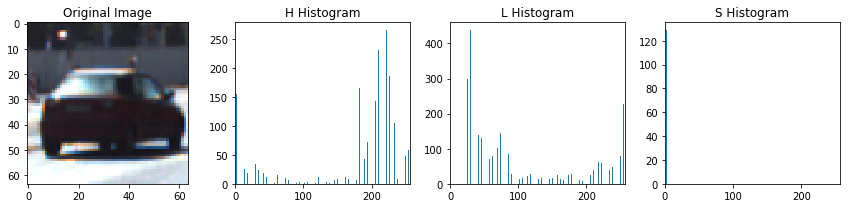

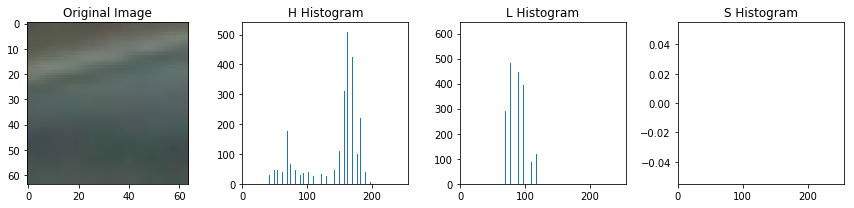

In [13]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Compute the histogram of the RGB channels separately
    hhist = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    lhist = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    shist = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    
    # Generating bin centers
    bin_centers = (hhist[1][1:]  + hhist[1][0:len(hhist[1])-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hhist[0], lhist[0], shist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hhist, lhist, shist, bin_centers, hist_features
    


for i in range(0, 5):
    
    if(np.random.random()>0.5):
        car_ind = np.random.randint(0, len(cars))
        image = mpimg.imread(cars[car_ind])
    else:
        notcar_ind = np.random.randint(0, len(notcars))
        image = mpimg.imread(notcars[notcar_ind])
    
    image = image*255
    
    h, l, s, bincen, feature_vec = color_hist(image, nbins=64, bins_range=(0, 256))
    # Plot a figure with all three bar charts
    if h is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(141)
        image = image/255
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(142)
        plt.bar(bincen, h[0])
        plt.xlim(0, 256)
        plt.title('H Histogram')
        plt.subplot(143)
        plt.bar(bincen, l[0])
        plt.xlim(0, 256)
        plt.title('L Histogram')
        plt.subplot(144)
        plt.bar(bincen, s[0])
        plt.xlim(0, 256)
        plt.title('S Histogram')
        fig.tight_layout()
        plt.savefig('output_images/histogram'+str(i), bbox_inches='tight')
        plt.show()
    else:
        print('Your function is returning None for at least one variable...')

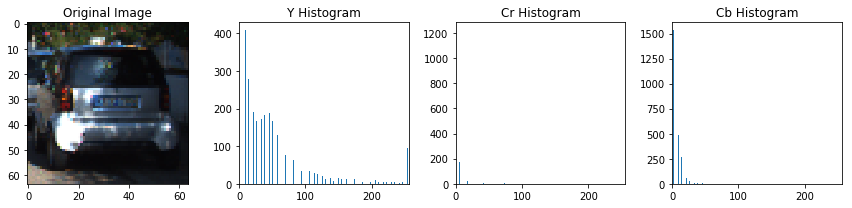

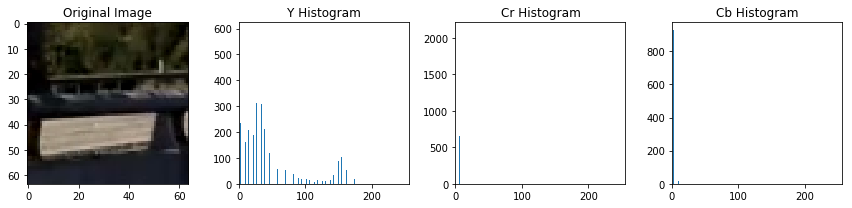

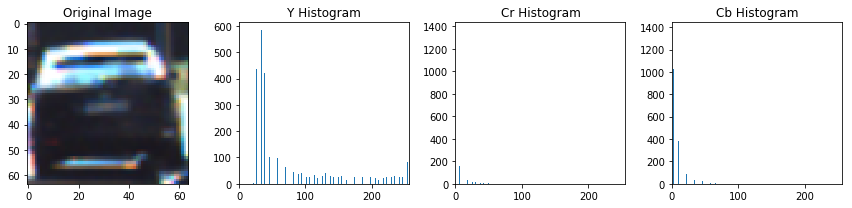

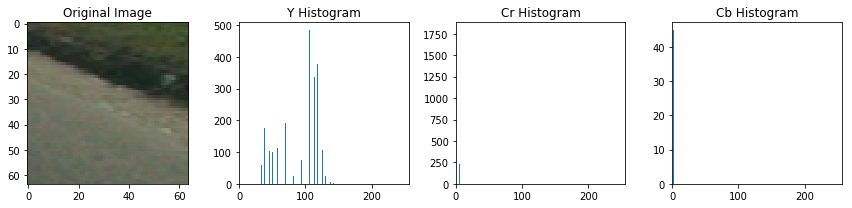

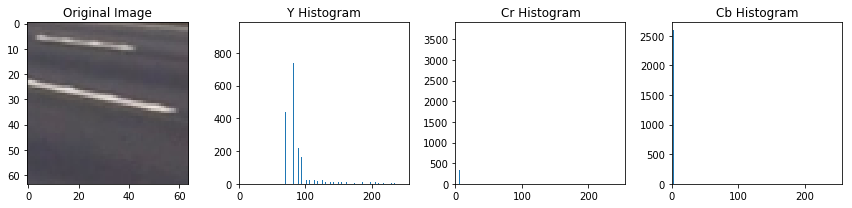

In [14]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    # Compute the histogram of the RGB channels separately
    yhist = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    crhist = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    cbhist = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    
    # Generating bin centers
    bin_centers = (yhist[1][1:]  + yhist[1][0:len(yhist[1])-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((yhist[0], crhist[0], cbhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return yhist, crhist, cbhist, bin_centers, hist_features
    


for i in range(0, 5):
    
    if(np.random.random()>0.5):
        car_ind = np.random.randint(0, len(cars))
        image = mpimg.imread(cars[car_ind])
    else:
        notcar_ind = np.random.randint(0, len(notcars))
        image = mpimg.imread(notcars[notcar_ind])
    
    image = image*255
    
    y, cr, cb, bincen, feature_vec = color_hist(image, nbins=64, bins_range=(0, 256))
    # Plot a figure with all three bar charts
    if y is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(141)
        image = image/255
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(142)
        plt.bar(bincen, y[0])
        plt.xlim(0, 256)
        plt.title('Y Histogram')
        plt.subplot(143)
        plt.bar(bincen, cr[0])
        plt.xlim(0, 256)
        plt.title('Cr Histogram')
        plt.subplot(144)
        plt.bar(bincen, cb[0])
        plt.xlim(0, 256)
        plt.title('Cb Histogram')
        fig.tight_layout()
        plt.savefig('output_images/histogram'+str(i), bbox_inches='tight')
        plt.show()
    else:
        print('Your function is returning None for at least one variable...')

## Spatial Binning
- When handling lot of images, it is always important to do Spatial Binning and the image is reduced to (32,32,3) dimension to fasten the processing.
- Different color spaces like HSV, HLS and LUV are tried to create the feature vector but "YCrCb" shows pure distinctive nature to recognize car and non car images.
- color_hist is the general histogram function.

In [15]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if(color_space == 'HSV'):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif(color_space == 'LUV'):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif(color_space == 'YCrCb'):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    img = cv2.resize(img, size)
    
    # Use cv2.resize().ravel() to create the feature vector
    features = img.ravel() 
    # Return the feature vector
    return features, img

In [16]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


## HOG Features
- Hog features are chosen from scikit library as mentioned in the class.
- Sample examples are shown below.
- When i choose orient to be 9, the trailings or barriers beside the road is classified into car. When i increase the orient value, the classification is better. I went up to 21 but it is not necessary i felt. So stuck with 19 and i get correct classification of cars in the same direction.
- When i dont scale the features to zero, then orient value can be set to 11 and the cars get classified properly. Since it is a requirement to scale the features to zero, I changed the orient values accordingly by testing it.
- Pixels per cell and Cells per block are kept same as in the lesson.
- Y Channel in YCrCb provides distinctive features with respect to car and non-car images.
- In extract_features function, Iam just using hog features.

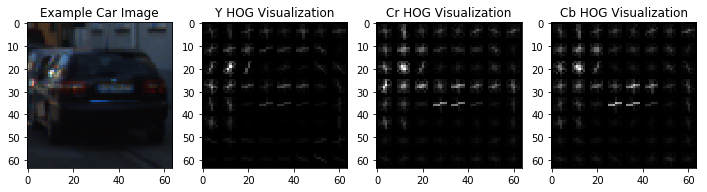

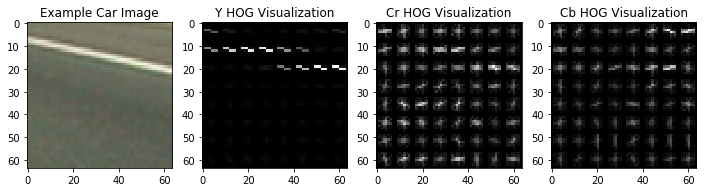

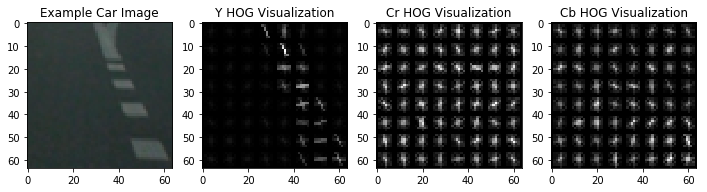

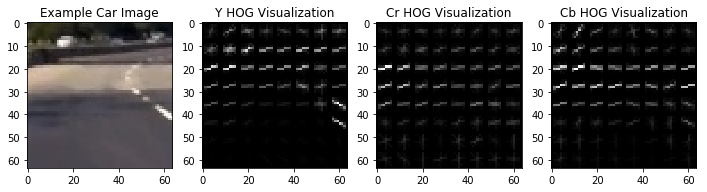

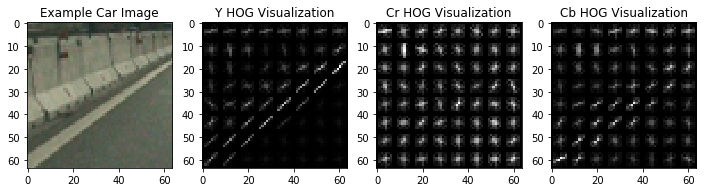

In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
for i in range(5):
    
    if(np.random.random()>0.5):
        car_ind = np.random.randint(0, len(cars))
        image = mpimg.imread(cars[car_ind])
    else:
        notcar_ind = np.random.randint(0, len(notcars))
        image = mpimg.imread(notcars[notcar_ind])
    
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    # Define HOG parameters
    orient = 19
    pix_per_cell = 8
    cell_per_block = 2
    
    # Call our function with vis=True to see an image output
    y_features, y_hog_image = get_hog_features(img_ycrcb[:,:,0], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    
    cr_features, cr_hog_image = get_hog_features(img_ycrcb[:,:,1], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    
    cb_features, cb_hog_image = get_hog_features(img_ycrcb[:,:,2], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    # Plot the examples
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(142)
    plt.imshow(y_hog_image, cmap='gray')
    plt.title('Y HOG Visualization')
    plt.subplot(143)
    plt.imshow(cr_hog_image, cmap='gray')
    plt.title('Cr HOG Visualization')
    plt.subplot(144)
    plt.imshow(cb_hog_image, cmap='gray')
    plt.title('Cb HOG Visualization')
    plt.savefig('output_images/hog_feat'+str(i), bbox_inches='tight')
    plt.show()


In [18]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [19]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


## Classifier
- SVM is used as classifier.
- The Standard Scaler function is used to normalize the data with 0 mean and equal variance.
- I chose SVM because it does not require much effort to tune the model because there are not many hyperparameters in the linear SVM to tune except the cost.
- I tried without normalizing but SVM classifies fine with lesser orientation values of hog features.
- Train Test Split of 80:20 is chosen.
- I felt SVM is the best classifier in this scenario and gave the best accuracy.
- I might try to ensemble the model with others but since I got good accuracy, i stuck with linear SVM.
- The accuracy is 98.56 percent on the test data as shown below in the result.
- Time taken to train and test with some data is presented.

In [20]:


#test_img = mpimg.imread('test_images/test1.jpg')
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=False, 
                    hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, cspace=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [21]:
cars=car_images
notcars=noncar_images
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 19
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

217.49 Seconds to extract HOG features...
Using: 19 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11172
295.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
1.68154 Seconds to predict 10 labels with SVC


## Find Cars

- This is the most important function which combines all the features put together to build the pipeline. 
- Spatial and Histogram features are not considered in this work.
- Hog features are considered.
- Feature vectors are constructed by hog features and fed into the trained SVM model to obtain the test prediction.
- ystart is chosen to be 400 in the image as per lesson and yend also.
- Scale is chosen to be 1.5 because 1 is too small box and 2 is very long.
- Sliding Window is also included in this with respect to choosing the starting and ending point of processing and deciding on the x and y positions.
- The blocks are divided and number of blocks per window is calculated. The number of windows chosen is 64.
- The number of cells per step was taken manually to be 2. Other parameters are calculated accordingly.
- For each block the hog feature is classified using the classifier and predicted the result of car and non-car. This approach would also help solve the overlapping window problem.
- Since this method is incorporated and works well, search window is also inside by searching through each block by block for features and it is classified by SVM by using HOG features.

In [22]:


orient = 19
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32

img = mpimg.imread('test_images/test1.jpg')
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = (np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1,-1))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles


In [23]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 19
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

13 rectangles found in image


## Draw Boxes

- The rectangles returned from find cars function are drawn on a test image.
- To make sure of the positions, heat map is implemented.
- Since there are more rectangles and apply threshold function would give us the absolute count of number of cars detected on the track.
- This is then depicted in draw labelled boxes from the thresholded image and in the example image it is 2 cars found.

In [24]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

                        

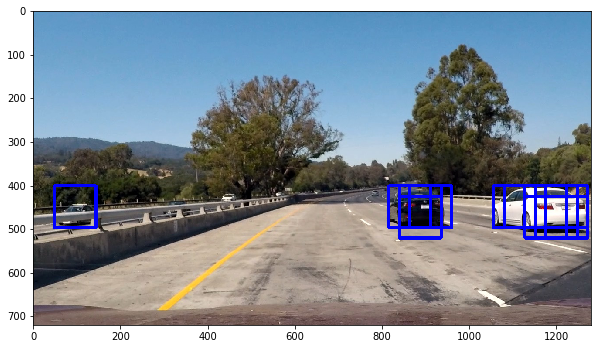

In [25]:
test_img_rects = draw_boxes(img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

In [26]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

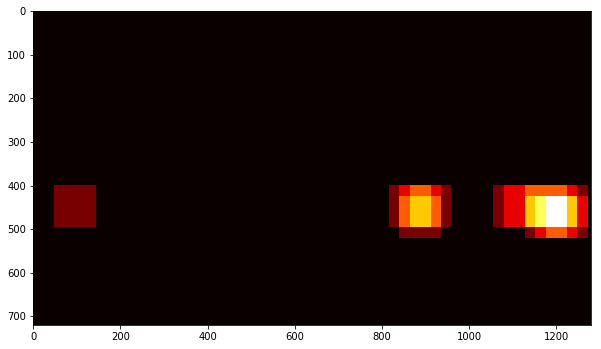

In [27]:
heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

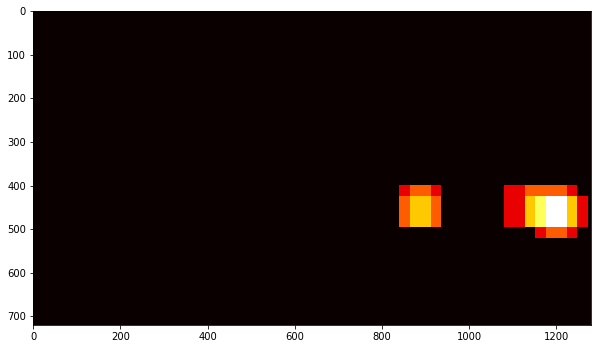

In [28]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


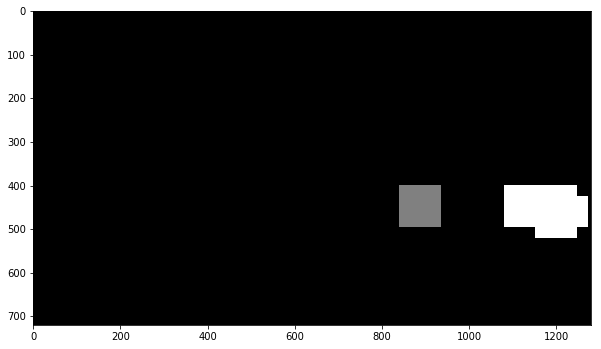

In [29]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

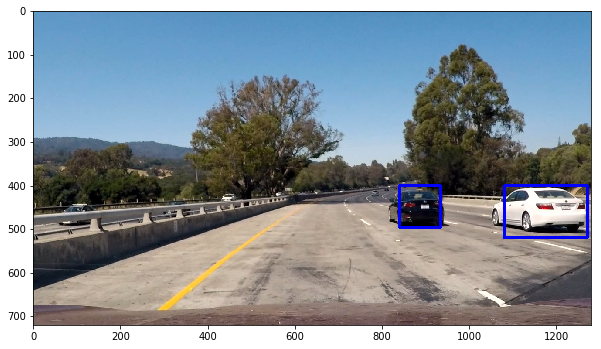

In [30]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

## Process frame pipeline
- This is again hardcoded seeing the images while testing.
- When the cars are found far from the viewer, then scale selected is 1, then relatively it is high if it is little near which is chosen to be 1.5.
- When the cars are found close, the scale chosen is 3.
- These rectangles are appended and then used for seach in all the images.
- The measurements are according to windows found in the image. Since it is chosen to be 64, I have chosen for scale 1 to have difference of 64, for scale value 2, i have chosen 128 and for scale value 3, i have chosen 192 for ystart and ystop difference values.
- It is then applied on the video as per shown.

In [31]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 19
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 592
    scale = 3
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 656
    scale = 3
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


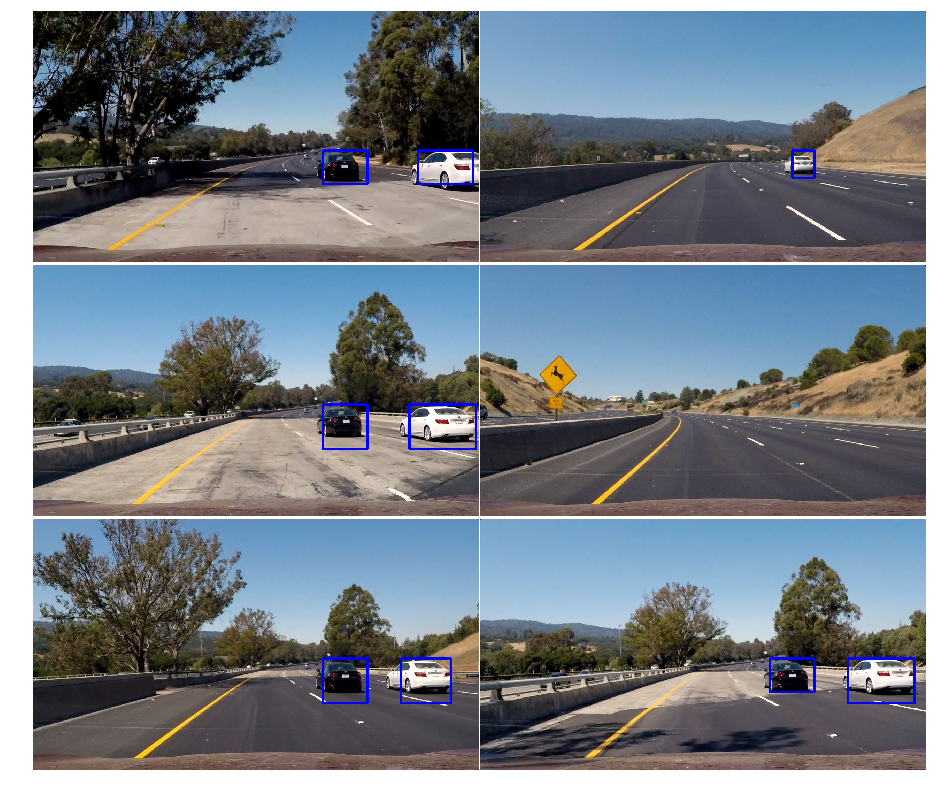

In [32]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [33]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  2.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 29.9 s, sys: 184 ms, total: 30.1 s
Wall time: 21.1 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [35]:
class Vehicle_Detection():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [36]:
def process_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 19
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 592
    scale = 3
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 656
    scale = 3
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [37]:
det = Vehicle_Detection()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  2.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 32 s, sys: 148 ms, total: 32.1 s
Wall time: 22.1 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [39]:
det = Vehicle_Detection()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [10:35<00:00,  2.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 16min 21s, sys: 3.26 s, total: 16min 24s
Wall time: 10min 36s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))

## Discussions

- One of the difficulties i faced was converting the images of png to jpg while processing.
- I could not implement perfectly the sliding window method and instead chose the manual processing.
- Improvements would be to try with dark backgrounds with different color channels to identify features. 
- I would also try to ensemble the classification models and might also use neural networks for classification.
- If the car changes the lane, it will be interesting to watch the detections in case of hypothetical situation.
- When the car is too close to the right, it would fail to detect.